In [211]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate
import pickle
import recmetrics
from sklearn.preprocessing import LabelEncoder

# Collaborative Filter Recommender
We are implementing a collaborative filtering using a SVD approach in the `surprise` package. The surprise package also takes care of the train test split. The collaborative filter 
transforms user-item interactions into latent space and reconstructs the user-item matrix to predict missing `relative_playcount` values based on the patterns it has learnt. The predicted 
rating is the dot product between the `Username` and `Track_Artist` vectors in latent space.

We will be taking the `Username`, `track_name` and `artist_name` and `playcount` from the `user_songs_filtered.csv` dataset.

The evaluation works by comparing the predicted songs using the SVD approach to the user's actual top 30 songs in the user's playlist

## Reading the CSV file

In [212]:
df = pd.read_csv('../Data/user_songs_filtered.csv')
df.head()

,Username,country,registered_year,track_count,artist_count,track_name,artist_name,rank,playcount,lyrics,...,emotion1,emotion1_score,emotion2,emotion2_score,mfcc,chroma,rms,spectral_centroid,zcr,tempo
0,emosoup,United States,2015,13520,3386,Higher,Sleep Token,1,1321,you say you wont begin again\ncapitulate and l...,...,negative,0.227031,sadness,0.156834,[-238.95233 173.60838 -18.518389 40.3...,[0.50727826 0.3796307 0.33886188 0.22625148 0...,0.146034,1508.885765,0.032354,77.133862
1,maiconslavieiro,Brazil,2019,18795,6513,Higher,Sleep Token,21,151,you say you wont begin again\ncapitulate and l...,...,negative,0.227031,sadness,0.156834,[-238.95233 173.60838 -18.518389 40.3...,[0.50727826 0.3796307 0.33886188 0.22625148 0...,0.146034,1508.885765,0.032354,77.133862
2,velenious,United States,2013,32367,8810,Higher,Sleep Token,19,1259,you say you wont begin again\ncapitulate and l...,...,negative,0.227031,sadness,0.156834,[-238.95233 173.60838 -18.518389 40.3...,[0.50727826 0.3796307 0.33886188 0.22625148 0...,0.146034,1508.885765,0.032354,77.133862
3,Antimemetic,United States,2023,4030,711,Higher,Sleep Token,32,29,you say you wont begin again\ncapitulate and l...,...,negative,0.227031,sadness,0.156834,[-238.95233 173.60838 -18.518389 40.3...,[0.50727826 0.3796307 0.33886188 0.22625148 0...,0.146034,1508.885765,0.032354,77.133862
4,frankcreature,Czech Republic,2023,2528,706,Higher,Sleep Token,43,43,you say you wont begin again\ncapitulate and l...,...,negative,0.227031,sadness,0.156834,[-238.95233 173.60838 -18.518389 40.3...,[0.50727826 0.3796307 0.33886188 0.22625148 0...,0.146034,1508.885765,0.032354,77.133862


## Creating the `Track_Artist` and `relative_playcount` column

`relative_playcount`: Represents the playcount of each song relative to the total playcount of the user  
`Track_Artist`: Combines both the `track_name` and the `artist_name`  
`Username`: the user

In [213]:
# Subsetting the important information from the orginal dataset
cf_df = df[['Username', 'track_name', 'artist_name', 'playcount']]

# Finding the total playcount per user
user_total_playcount = cf_df.groupby('Username')['playcount'].transform('sum')

# Creating the relative_playcount column
cf_df['relative_playcount'] = cf_df['playcount'] / user_total_playcount

# Creating the Track_Artist column
cf_df['Track_Artist'] = cf_df['artist_name'] + ' - ' + cf_df['track_name']

cf_df.head()

/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_21139/2940023715.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cf_df['relative_playcount'] = cf_df['playcount'] / user_total_playcount
/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_21139/2940023715.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cf_df['Track_Artist'] = cf_df['artist_name'] + ' - ' + cf_df['track_name']


,Username,track_name,artist_name,playcount,relative_playcount,Track_Artist
0,emosoup,Higher,Sleep Token,1321,0.035110,Sleep Token - Higher
1,maiconslavieiro,Higher,Sleep Token,151,0.021730,Sleep Token - Higher
2,velenious,Higher,Sleep Token,1259,0.019800,Sleep Token - Higher
3,Antimemetic,Higher,Sleep Token,29,0.018012,Sleep Token - Higher
4,frankcreature,Higher,Sleep Token,43,0.009453,Sleep Token - Higher


Using Label Encoding to assign a unique integer to each unique `Track_Artist` to create a `Track_Artist_id` column

In [214]:
label_encoder = LabelEncoder()

# Fit label encoder and transform Track_Artist column
cf_df['Track_Artist_id'] = label_encoder.fit_transform(cf_df['Track_Artist'])

# Display the result
print(cf_df[['Track_Artist', 'Track_Artist_id']].drop_duplicates())

/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_21139/319584608.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cf_df['Track_Artist_id'] = label_encoder.fit_transform(cf_df['Track_Artist'])


                                            Track_Artist  Track_Artist_id
0                                   Sleep Token - Higher           110374
16                       Sleep Token - The Love You Want           110394
29                              Sleep Token - Dark Signs           110362
43                                Sleep Token - Alkaline           110351
74        Sleep Token - The Night Does Not Belong to God           110395
...                                                  ...              ...
393115                           guccihighwaters - candy           144645
393116  Candy Claws - Fallen Tree Bridge (Brave Rainbow)            22536
393117                  Candy Claws - The Breathing Fire            22550
393118    Sound of Ceres - Solar Mirror Anthology Vol. 6           112338
393119  |||||||||||||||||||| - Outlook Remains Untouched           147259

[147592 rows x 2 columns]


In [215]:
filtered_df = cf_df[(cf_df['Username'] == 'fleuriana') & (cf_df['Track_Artist_id'] == 87229)]
print(filtered_df)

         Username                    track_name artist_name  playcount  \
383532  fleuriana  Banana Clip (feat. Mowalola)   Namasenda        332   

        relative_playcount                              Track_Artist  \
383532            0.032845  Namasenda - Banana Clip (feat. Mowalola)   

        Track_Artist_id  
383532            87229  


In [216]:
cf_df = cf_df.drop(['track_name', 'artist_name', 'playcount', 'Track_Artist'], axis=1)
cf_df.head()

,Username,relative_playcount,Track_Artist_id
0,emosoup,0.035110,110374
1,maiconslavieiro,0.021730,110374
2,velenious,0.019800,110374
3,Antimemetic,0.018012,110374
4,frankcreature,0.009453,110374


## Model Training and Testing

In [217]:
# Define the reader
reader = Reader(rating_scale=(cf_df['relative_playcount'].min(), cf_df['relative_playcount'].max()))

# Load the data into Surprise's Dataset
data = Dataset.load_from_df(cf_df[['Username', 'Track_Artist_id', 'relative_playcount']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the SVD algorithm
model = SVD()

# Train the model on the training set
model.fit(trainset)

# Make predictions for the test data
predictions = model.test(testset)

`actual`: The actual relative_playcount value  
`cf_predictions`: predicted relative_playcount values generated by the SVD model for the user-item pairs in the test set

In [218]:
test_df = pd.DataFrame(predictions)
test_df.drop("details", inplace=True, axis=1)
test_df.columns = ['Username', 'Track_Artist_id', 'actual', 'cf_predictions']
test_df.head()

,Username,Track_Artist_id,actual,cf_predictions
0,fleuriana,87229,0.032845,0.046241
1,vampiyr,16650,0.016518,0.043182
2,maLOLory,113353,0.021589,0.000001
3,Alarmando,118286,0.024300,0.110399
4,stephenct1,127671,0.025274,0.014733


## Evaluation Metrics

### RMSE & MSE

In [219]:
print("MSE: ", recmetrics.mse(test_df.actual, test_df.cf_predictions))
print("RMSE: ", recmetrics.rmse(test_df.actual, test_df.cf_predictions))

MSE:  0.003225169079052343
RMSE:  0.056790572096540315


### Mean Average Recall at K (MAR@K)
This will provide the average measure of the systems's ability to recommend relevant items within the top-K recommendations for all user

In [220]:
#create model (matrix of predicted values)
cf_model = test_df.pivot_table(index='Username', columns='Track_Artist_id', values='cf_predictions').fillna(0)

Retrieving all the actual `Track_Artist_id` and grouping them per user

In [221]:
test = test_df.copy().groupby('Username', as_index=False)['Track_Artist_id'].agg({'actual': (lambda x: list(set(x)))})
test.head()

,Username,actual
0,-Dolorosa-,"[25316, 110889, 33774, 54239, 137368, 137177, ..."
1,-itssoeasy,"[58274, 29190, 26668, 105934, 58257, 67994, 58..."
2,0-172,"[31522, 31499, 108881, 108882, 109203, 103768,..."
3,23linear,"[61732, 6984, 91178, 35244, 84408, 81788]"
4,40belowsummer,"[63619, 9892, 33351, 2696, 15821, 16943, 17104..."


In [222]:
test = test.set_index("Username")

This function gets the users song predictions generated by the SVD

In [223]:
def get_users_predictions(username, n, model):
    recommended_items = pd.DataFrame(model.loc[username])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [224]:
#get example prediction
get_users_predictions('-Dolorosa-', 30, cf_model)

[25308,
 25316,
 137368,
 33774,
 137375,
 137177,
 54239,
 110889,
 128538,
 6,
 97955,
 97943,
 97944,
 97945,
 97951,
 97953,
 97962,
 97958,
 97960,
 97940,
 97964,
 97966,
 97969,
 97971,
 97975,
 97977,
 97979,
 97941,
 97933,
 97939]

Creates a dataframe with the user's actual top 30 songs based on `relative_playcount` and the SVD model prediction

In [225]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 30, cf_model)
    cf_recs.append(cf_predictions)
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
Username,,
-Dolorosa-,"[25316, 110889, 33774, 54239, 137368, 137177, ...","[25308, 25316, 137368, 33774, 137375, 137177, ..."
-itssoeasy,"[58274, 29190, 26668, 105934, 58257, 67994, 58...","[58274, 68383, 58300, 67994, 29190, 105934, 26..."
0-172,"[31522, 31499, 108881, 108882, 109203, 103768,...","[109203, 108882, 103770, 31522, 31499, 108881,..."
23linear,"[61732, 6984, 91178, 35244, 84408, 81788]","[6984, 81788, 84408, 91178, 35244, 61732, 6, 9..."
40belowsummer,"[63619, 9892, 33351, 2696, 15821, 16943, 17104...","[85885, 86223, 85883, 16943, 17104, 101912, 98..."


In [226]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
# pop_predictions = test.pop_predictions.values.tolist()

In [227]:
cf_mark = []
for K in np.arange(1, 31):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.14395817499583707,
 0.28390706533246335,
 0.4177892749347575,
 0.5427385169630206,
 0.6546312069760905,
 0.7496849014204752,
 0.8270309219533455,
 0.8866366114941437,
 0.9299282052341402,
 0.9589762876848352,
 0.9775263747778598,
 0.9886621627283724,
 0.9948039294367103,
 0.997642500079666,
 0.9990115020975351,
 0.9995997486817682,
 0.9998516901383372,
 0.9999360608738557,
 0.9999794009184175,
 0.9999949758337605,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

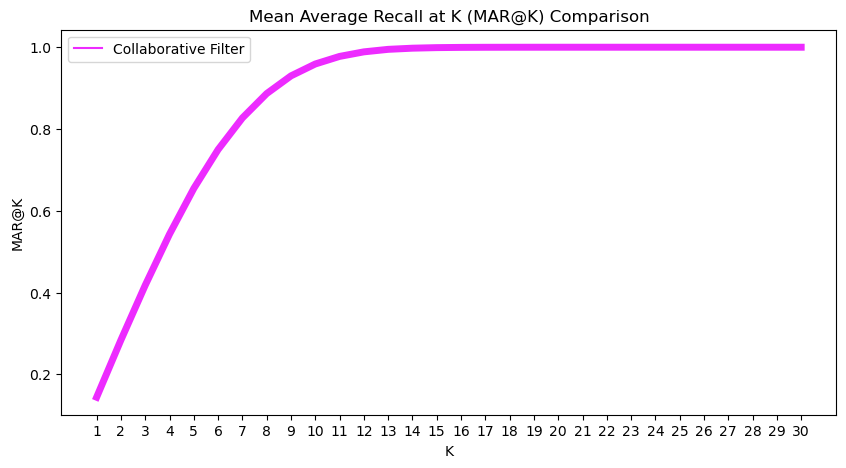

In [228]:
mark_scores = [cf_mark]
index = range(1,30+1)
names = ['Collaborative Filter']

fig = plt.figure(figsize=(10, 5))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

### Coverage and Novelty
- coverage will cover the percent of songs that the recommender is able to recommend in comparison with all the songs that is available
- novelty will measure the capacity of the recommeder system to propose novel and unexpected items which a user is likely to know about already. It uses the self-information of the recommended item and it calculates the mean self-information per top-N recommended list and averages them over all users.

In [229]:
all_track_artist = cf_df.Track_Artist_id.unique().tolist()
cf_coverage = recmetrics.prediction_coverage(cf_recs, all_track_artist)

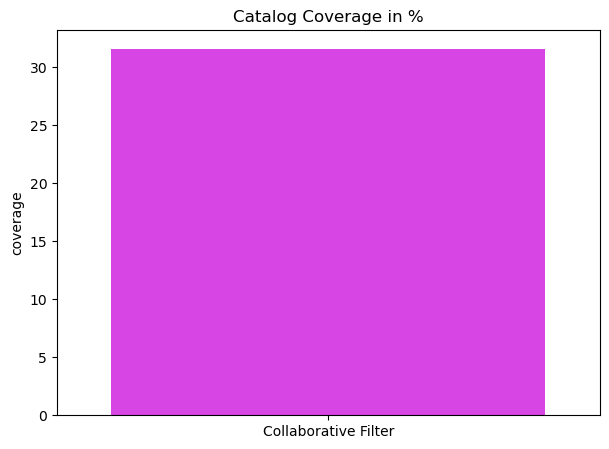

In [230]:
# plot of prediction coverage
coverage_scores = [cf_coverage]
model_names = ['Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

In [231]:
nov = cf_df.Track_Artist_id.value_counts()
pop = dict(nov)

In [232]:
cf_novelty,cf_mselfinfo_list = recmetrics.novelty(cf_recs, pop, len(cf_model.index), 10)

In [233]:
print(cf_novelty)

33.1870456710914


## Saving the model

In [234]:
SVD_pickle_file = "BaseModel.pkl"
with open(SVD_pickle_file, 'wb') as file:  
    pickle.dump(model, file)